In [3]:
from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt

from scipy.stats import t, normaltest, bartlett, levene

from pingouin import anova
from pingouin import welch_anova

from pingouin import pairwise_tukey, pairwise_gameshowell

In [4]:
my_dpi = 200                                    # 이미지 선명도(100~300)
font_path = "./NotoSansKR-Regular.ttf"          # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)               # 폰트의 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname=font_path)  # 폰트의 속성을 읽어옴
font_name = font_prop.get_name()                # 읽어온 속성에서 폰트의 이름만 추출     
plt.rcParams['font.family'] = font_name         # 그래프에 한글 폰트 적용
plt.rcParams['font.size'] = 10                  # 기본 폰트크기
plt.rcParams['axes.unicode_minus'] = False      # 그래프에 마이너스 깨짐 방지(한글환경에서 필수)

In [5]:
origin = load_data('poisons')

print("\n===== 데이터 크기 확인=====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 타입확인 =====")
print(origin.info())
origin

[data] https://data.hossam.kr/data/lab10_/poisons.xlsx
[desc] 독극물 종류별로 동물의 생존시간을 기록한 실험 데이터 (출처: 방송통신대학교 통계학 개론)

field    description
-------  ------------------
time     동물의 생존시간
poison   사용된 독극물 종류
treat    사용되는 치료 유형


===== 데이터 크기 확인=====
데이터셋 크기: (360, 3)
열 개수: 3
행 개수: 360

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    360 non-null    float64
 1   poison  360 non-null    object 
 2   treat   360 non-null    object 
dtypes: float64(1), object(2)
memory usage: 8.6+ KB
None


,time,poison,treat
0,3.8,P1,T1
1,2.7,P1,T1
2,1.7,P1,T1
3,2.2,P1,T1
4,0.7,P1,T1
...,...,...,...
355,4.7,P3,T4
356,4.9,P3,T4
357,4.9,P3,T4
358,4.5,P3,T4


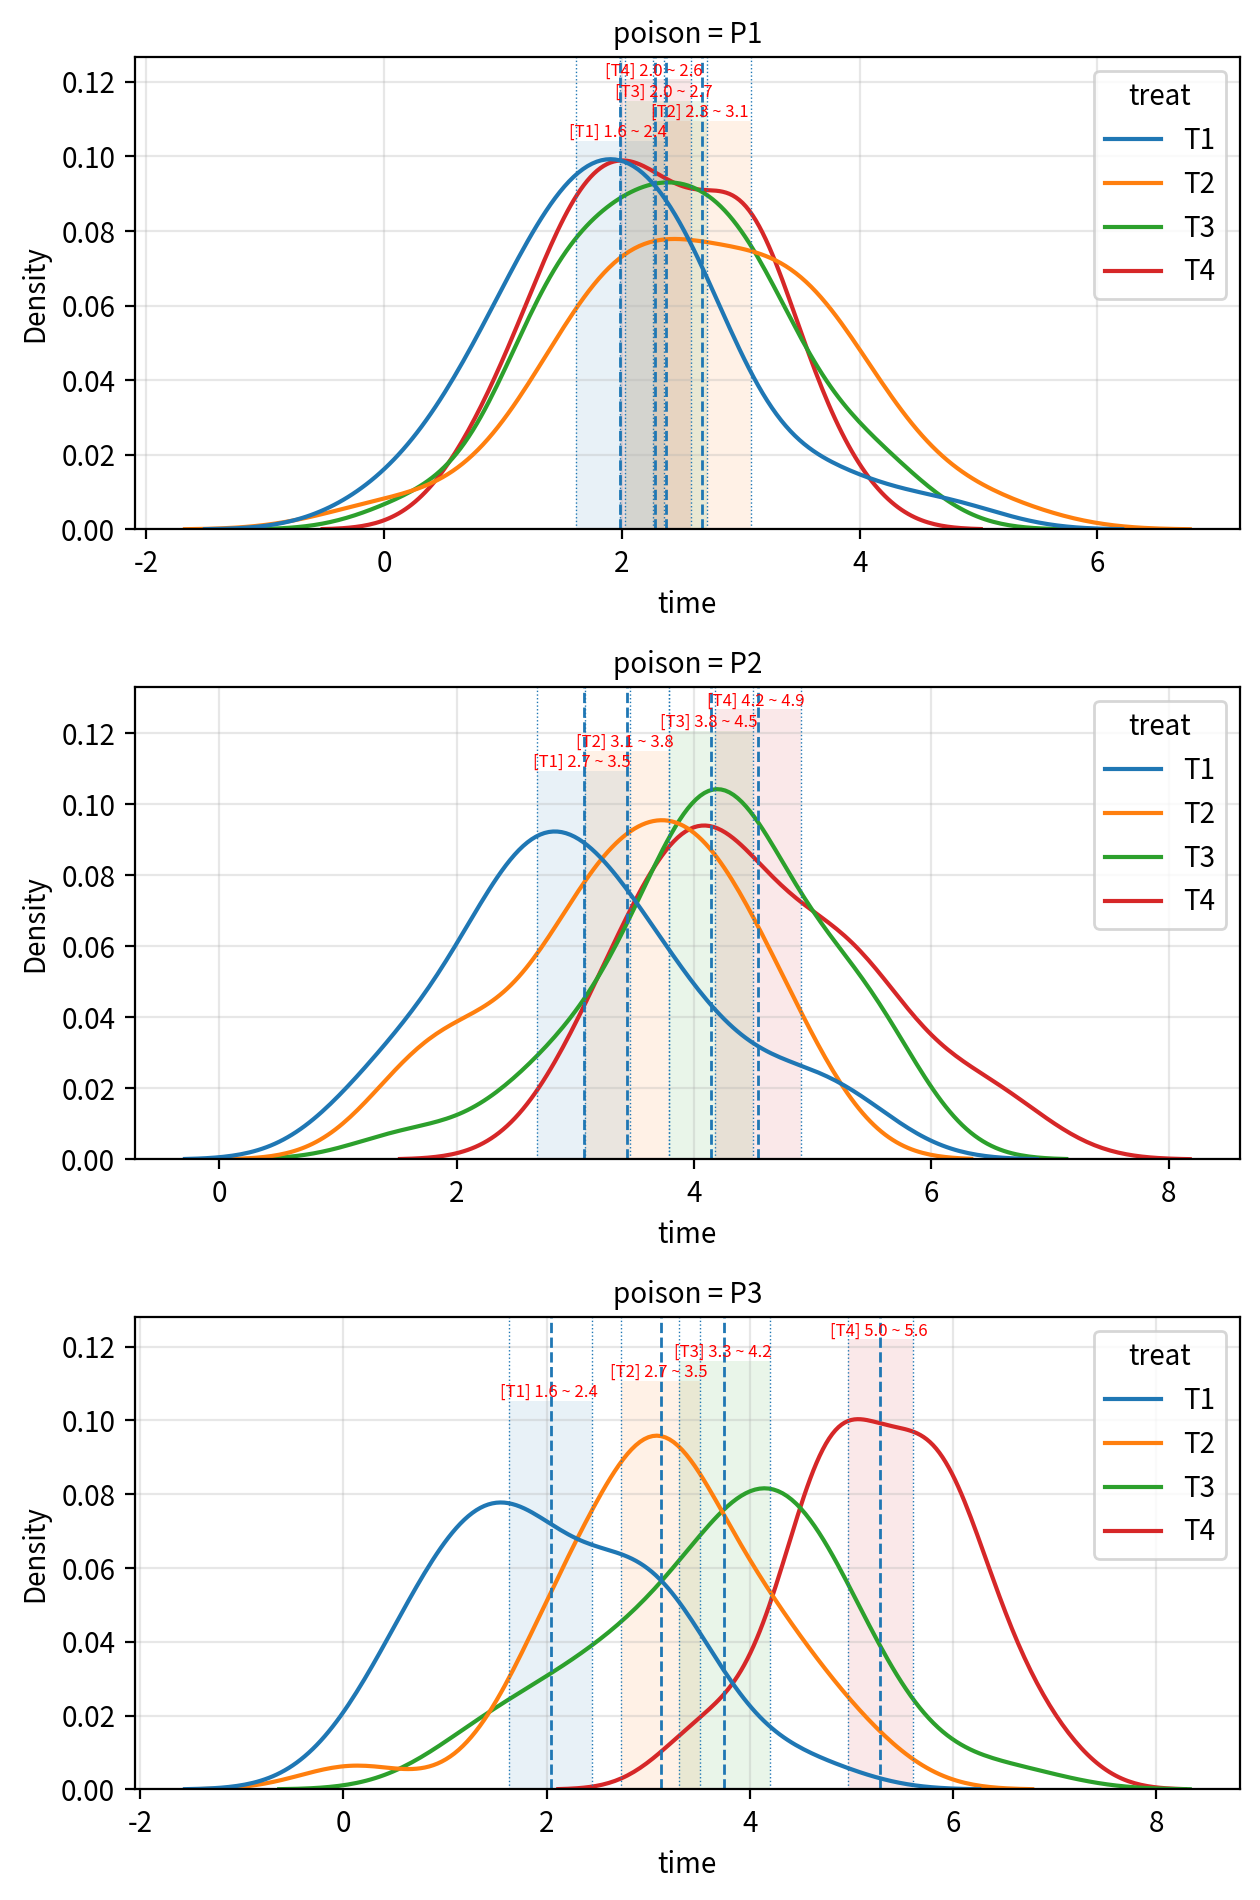

In [6]:
field = 'time'
group_field='poison'
hue_field='treat'

#시각화 할 필드만 원본 데이터에서 추출
data = origin[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)

hue_values = data[hue_field].unique()



rows = group_count
cols = 1
width_px = 1280 * cols
height_px = 640 * rows

figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)


for i,v in enumerate(group_values):
    temp = data[data[group_field]== v]

    sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]

        max= temp_sub[field].max()
        clevel = 0.95
        dof = len(temp_sub[field]) - 1
        sp_mean = temp_sub[field].mean()
        sp_std = temp_sub[field].std(ddof=1)
        sp_std_error = sp_std / sqrt(len(temp_sub[field]))
        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
        ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin,cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

        ax[i].text(x=(cmax-cmin)/2+cmin, y=ymax,
         s="[%s] %0.1f ~ %0.1f " % (h, cmin, cmax), horizontalalignment="center",
        verticalalignment="bottom",fontdict={"size":6, "color":"red"})



plt.tight_layout()
plt.show()
plt.close()






같은 독극물이라도 치료 방법에 따라 생존시간에 차이를 보이는 것 같지만, 명확한 판별은 어렵다.

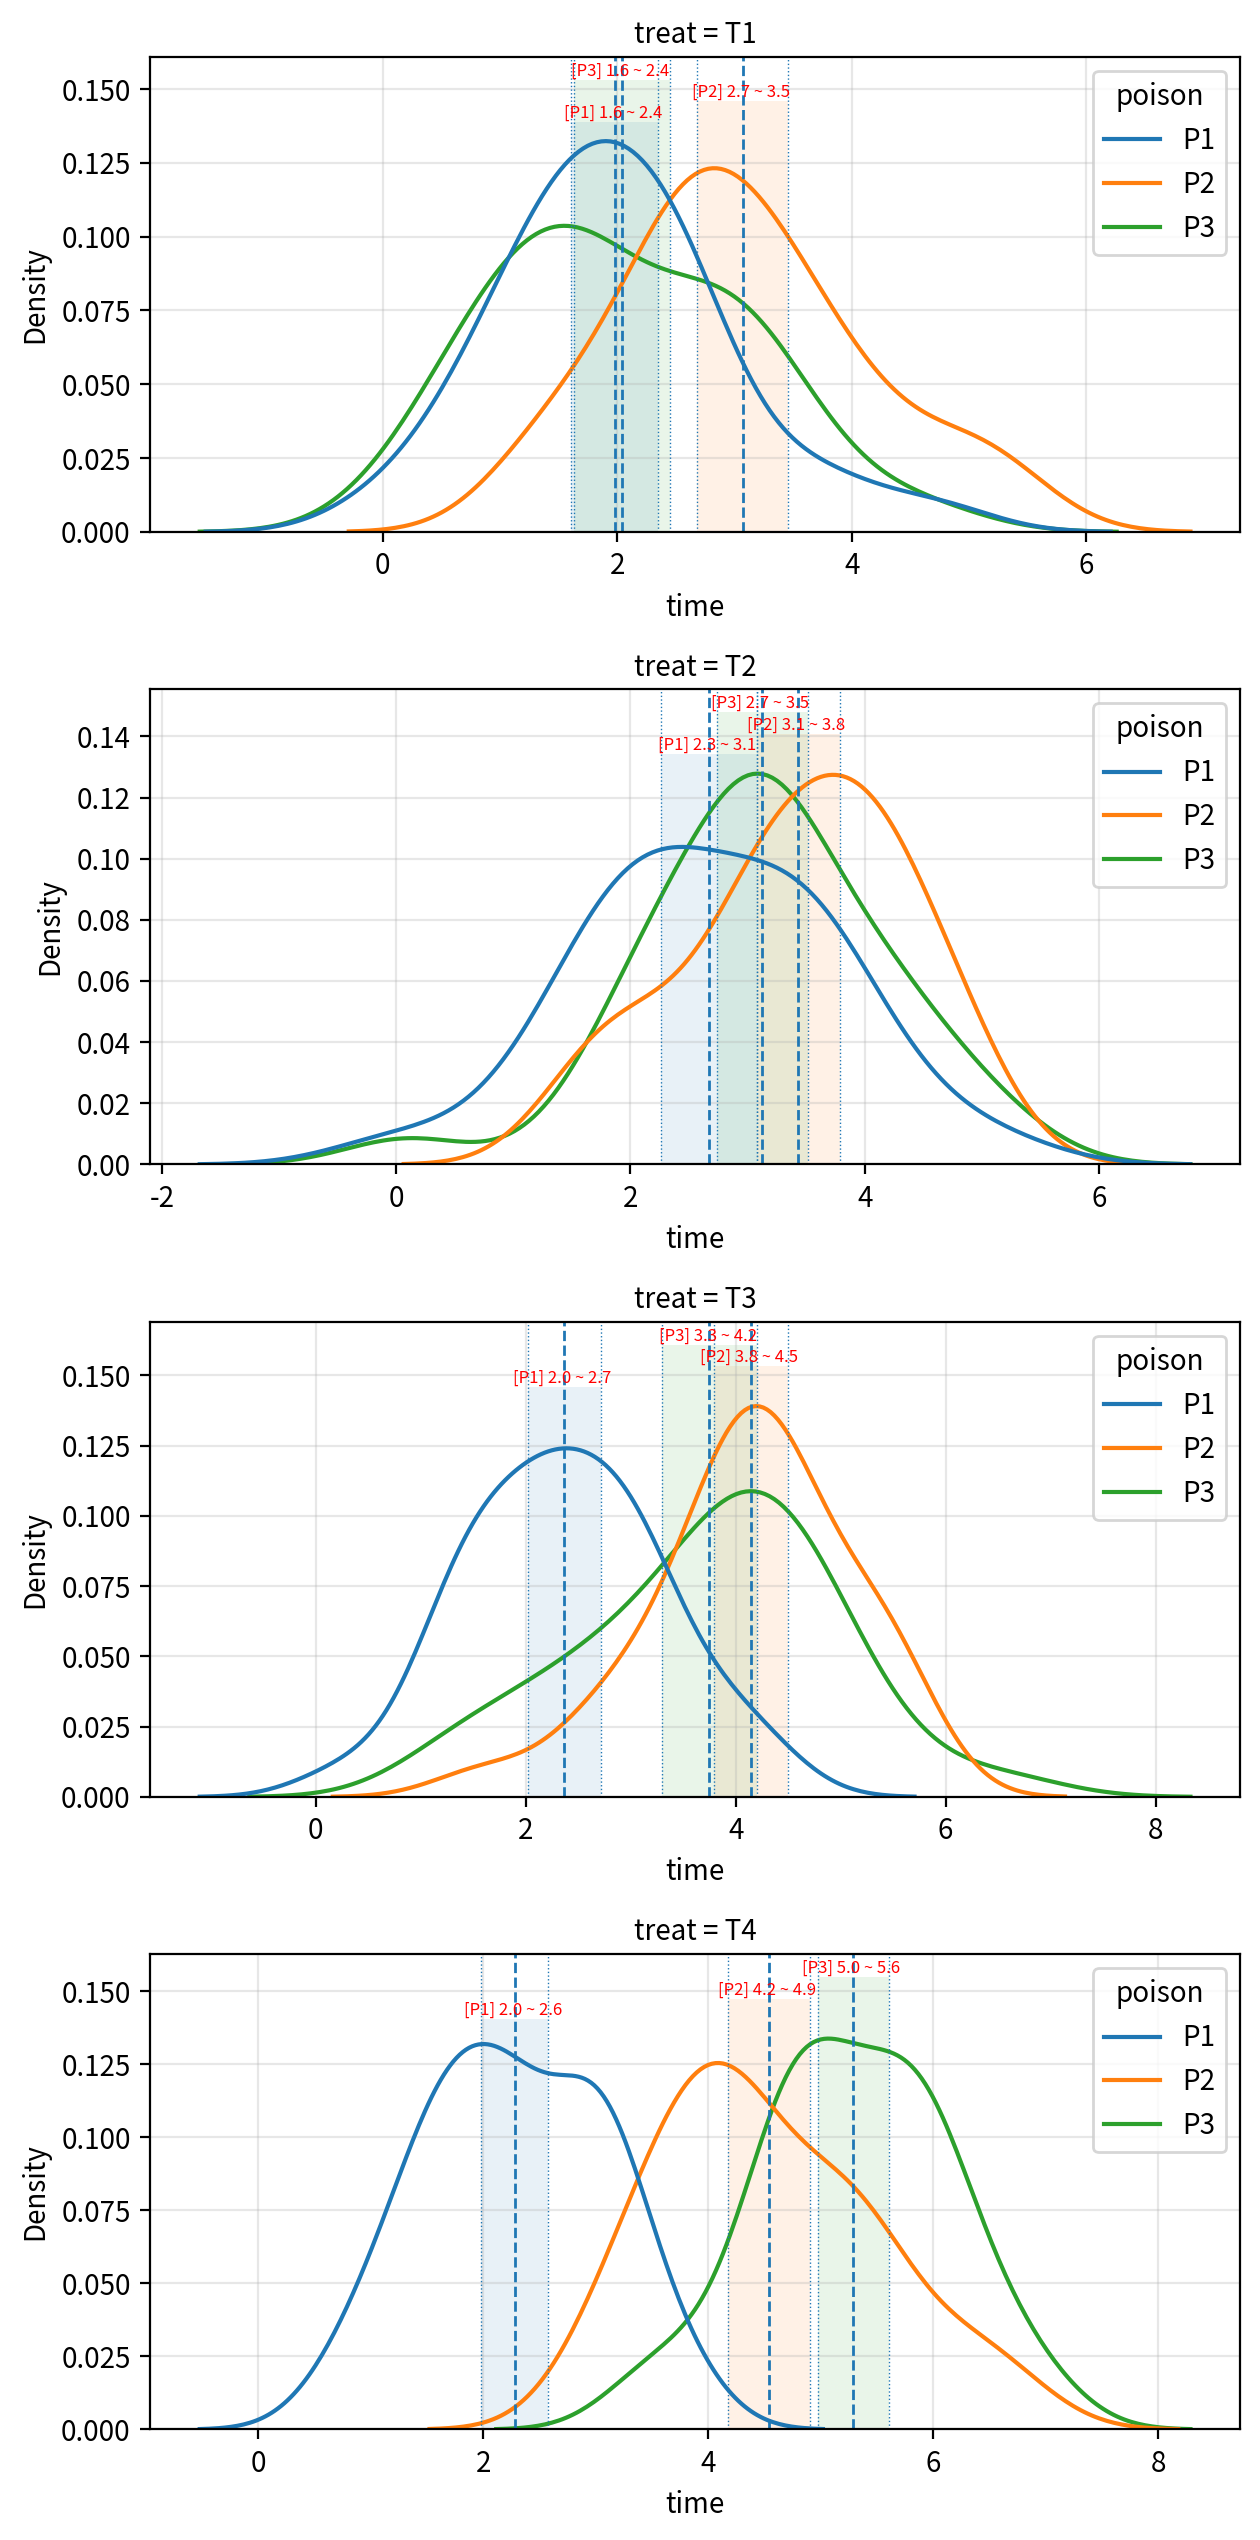

In [7]:
field = 'time'
group_field = 'treat'
hue_field = 'poison'

# 시각화 할 필드만 원본 데이터에서 추출
data = origin[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)

hue_values = data[hue_field].unique()

rows = group_count
cols = 1
width_px = 1280 * cols
height_px = 640 * rows

figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)


for i,v in enumerate(group_values):
    temp = data[data[group_field]== v]

    sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]

        max = temp_sub[field].max()
        clevel = 0.95
        dof = len(temp_sub[field]) - 1
        sp_mean = temp_sub[field].mean()
        sp_std = temp_sub[field].std(ddof=1)
        sp_std_error = sp_std / sqrt(len(temp_sub[field]))
        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
        ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin,cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

        ax[i].text(x=(cmax-cmin)/2+cmin, y=ymax,
         s="[%s] %0.1f ~ %0.1f " % (h, cmin, cmax), horizontalalignment="center",
        verticalalignment="bottom",fontdict={"size":6, "color":"red"})



plt.tight_layout()
plt.show()
plt.close()





T1, T2, T3에서는 P2에 대한 생존시간이 가장 길었지만, T4에서는 P3에 대한 생존시간이 긴것으로 보인다.

In [8]:
data = origin.copy()
xname = ['treat', 'poison']
yname = 'time'

u1 = data[xname[0]].unique()
u2 = data[xname[1]].unique()
equal_var_fields = []
normal_dist = True
report = []

for i in u1:
    for j in u2:
        filtered_data = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname]
        equal_var_fields.append(filtered_data)
        s, p = normaltest(filtered_data)

        normalize = p>0.05
        report.append({
            "field":  "{0}, {1}".format(i, j),
            "statistic": s,
            "p-value": p,
            "result": normalize
        })
        normal_dist = normal_dist and normalize


if normal_dist:
    n = "Bartlett"

    s,p = bartlett(*equal_var_fields)

else:
    n = "Levene"

    s,p = levene(*equal_var_fields)

equal_var = p>0.05

report.append({
    "field": n,
    "statistic": s,
    "p-value": p,
    "result": p > 0.05
    })

report_df =DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
"T1, P1",3.660816,0.160348,True
"T1, P2",1.112279,0.573418,True
"T1, P3",0.837473,0.657878,True
"T2, P1",0.266462,0.875263,True
"T2, P2",1.509951,0.470022,True
"T2, P3",3.667273,0.159831,True
"T3, P1",0.014374,0.992839,True
"T3, P2",2.802084,0.246340,True
"T3, P3",0.424600,0.808722,True


In [9]:
xname = ['treat', 'poison']
yname = 'time'
data = origin[xname + [yname]]

if equal_var:
    pg_anova = anova(data=data, dv=yname,between=xname)

else: 
    pg_anova = welch_anova(data=data, dv=yname, between=xname)

display(pg_anova)

for idx in pg_anova.index:
    row = pg_anova.iloc[idx]
    source = row['Source']
    p_val = row['p-unc']

    if p_val <= 0.05:
        print(f"-> {source} 효과는 유의함. (대립가설 채택: p<=0.05)")
    else:
        print(f"-> {source} 효과는 유의하지 않음. (귀무가설 채택: p>0.05)")


,Source,SS,DF,MS,F,p-unc,np2
0,treat,131.260972,3,43.753657,43.891090,4.430485e-24,0.274506
1,poison,148.976389,2,74.488194,74.722166,1.002877e-27,0.300424
2,treat * poison,81.381611,6,13.563602,13.606206,6.938981e-14,0.190014
3,Residual,346.910333,348,0.996869,NaN,NaN,NaN


-> treat 효과는 유의함. (대립가설 채택: p<=0.05)
-> poison 효과는 유의함. (대립가설 채택: p<=0.05)
-> treat * poison 효과는 유의함. (대립가설 채택: p<=0.05)
-> Residual 효과는 유의하지 않음. (귀무가설 채택: p>0.05)


In [12]:
xname = ['treat', 'poison']
yname = 'time'
data = origin[xname + [yname]]



for index, row in pg_anova.iterrows():      #행을 하나씩 꺼냄!!
    source_name = row['Source']
    p_value = row['p-unc']
  

    if source_name == "Residual" or "*" in source_name:
        continue

    print(f"\n==== {source_name} ====")

    if "*" not in source_name:
        level_count = data[source_name].nunique()   #요인의 수준 수계산

        if level_count <=2:
            print(f"{level_count} 수준 요인이므로 사후검정이 필요없습니다.")
            continue



    if p_value> 0.05:
        print(f"{source_name} 효과 유의하지 않음 (p={p_val:.3g}) ->사후검정 수행 안함")
        continue
    

    if equal_var:
        print(f"Tukey HSD 사용(등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=source_name)

    else:
        print(f"Games-Howell 사용 (등분산 불충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=source_name)
    
    display(hoc_df)




==== treat ====
Tukey HSD 사용(등분산 충족)


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,T1,T2,2.363333,3.075556,-0.712222,0.189827,-3.751957,1.168920e-03,-0.639750
1,T1,T3,2.363333,3.421111,-1.057778,0.189827,-5.572330,2.971230e-07,-0.867932
2,T1,T4,2.363333,4.034444,-1.671111,0.189827,-8.803345,6.006307e-14,-1.220199
3,T2,T3,3.075556,3.421111,-0.345556,0.189827,-1.820373,2.654092e-01,-0.292572
4,T2,T4,3.075556,4.034444,-0.958889,0.189827,-5.051387,4.181336e-06,-0.717648
5,T3,T4,3.421111,4.034444,-0.613333,0.189827,-3.231015,7.343056e-03,-0.430346



==== poison ====
Tukey HSD 사용(등분산 충족)


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,P1,P2,2.325000,3.795833,-1.470833,0.161626,-9.100235,5.107026e-14,-1.388884
1,P1,P3,2.325000,3.550000,-1.225000,0.161626,-7.579233,9.585666e-13,-0.931693
2,P2,P3,3.795833,3.550000,0.245833,0.161626,1.521002,2.822579e-01,0.179210


1) 분석 목적
본 분석은 동물의 생존시간(survival time) 에 대해
사용된 독극물의 종류(poison) 와 치료 유형(treat) 이 어떠한 영향을 미치는지를 검증하기 위해 이원분산분석(two-way ANOVA) 을 수행하였다.

2) 분산분석 주요 결과
treat: F = 43.89, p = 4.43e-24, ηp² = 0.2745 → 유의함(대립가설 채택)
poison: F = 74.72, p = 1.00e-27, ηp² = 0.3004 → 유의함(대립가설 채택)
treat × poison: F = 13.61, p = 6.94e-14, ηp² = 0.1900 → 유의함(대립가설 채택)
독극물의 종류, 치료 유형, 그리고 두 요인의 조합 모두 생존시간에 의미 있는 차이를 만든다.
즉, 특정 치료가 특정 독극물에서 더 효과적일 수 있음을 시사한다.

3) 기술통계 및 집단별 평균 비교
treat 수준별 평균
T1: 2.36
T2: 3.08
T3: 3.42
T4: 4.03
→ 치료 강도가 높아질수록 평균 생존시간이 증가하는 경향.

poison 수준별 평균
P1: 2.33
P2: 3.80
P3: 3.55
→ P1이 가장 독성이 강해 생존시간이 가장 짧고, P2가 상대적으로 가장 길다.

4) 사후검정(Post-hoc) 결과
treat: 4수준 + 주효과 유의 → Tukey HSD 수행
주요 차이: T1은 T2, T3, T4보다 모두 유의하게 생존시간이 짧음(p < .01)
T4는 T2, T3보다도 유의하게 더 김
T2–T3는 유의하지 않음

poison: 3수준 + 주효과 유의 → Tukey HSD 수행
주요 차이: 
P1 < P2 (p < .001)
P1 < P3 (p < .001)
P2–P3는 유의하지 않음

상호작용(simple effects):
상호작용이 유의하므로 조합별 비교가 필요함
치료 유형 간에는 명확한 서열(T4 > T3 ≈ T2 > T1)이 확인되며, 독극물 효과는 P1이 압도적
으로 독성이 강하다.

5) 최종 결론 요약
 
• 치료 유형은 생존시간에 뚜렷한 차이를 만들며, T4가 가장 효과적이고 T1이 가장 낮다.
• 독극물은 생존시간에 강한 영향을 주며, P1이 가장 치명적이다.
• 치료와 독극물 간에는 의미 있는 상호작용이 존재하여, 특정 치료는 특정 독극물에서 특히 더 효과적이다.
• 사후검정 결과, 대부분의 의미 있는 차이가 치료 서열(T4 > T3 ≈ T2 > T1) 및 독극물독성(P1 < P3 ≈ P2)을 명확히 보여준다.
(최종 한 문장 결론: 동물의 생존시간은 독극물의 종류와 치료 유형 모두에 강하게 영향을 받으
며, 두 요인의 조합 또한 생존시간 차이를 유의하게 만들어낸다.)